<a href="https://colab.research.google.com/github/DanieloSendi/Deep-Learning-Labs/blob/main/02_Getting_Started_with_DNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Simple DNN 2 - Binary classification, Hyperparameters, Callbacks**
***

## **Part 1 Binary classification problem**

Two-class classification, or binary classification, may be the most widely applied kind of machine learning problem. The aim of this lab is to classify movie reviews into “positive” reviews and “negative” reviews, just based on the text content of the reviews.

### 1. Import libraries

In [ ]:
from tensorflow import keras
from tensorflow.keras.datasets import imdb
import tensorflow as tf
from keras import models, layers
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install scikeras -q

from sklearn.model_selection import GridSearchCV
# from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
# in Google Colab you may need to use !pip install scikeras
# in a block before for it to work properly.

In [ ]:
!pip install keras-tuner --upgrade -q
import keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.8 MB/s eta 0:00:00


### 2. Load the IMDB dataset from Keras

We'll be working with the “IMDB dataset”, a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews. Just like the MNIST dataset, the IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

In [ ]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


 The argument `num_word`=10000 means that we will only keep the top 10,000 most frequently occurring words in the training data. Rare words will be discarded. This allows us to work with vector data of manageable size.

### 3. Preparing the data

We cannot feed lists of integers into a neural network. We have to turn our lists into tensors. There are two ways we could do that:

- We could pad our lists so that they all have the same length, and turn them into an integer tensor of shape (samples, word_indices), then use as the first layer in our network a layer capable of handling such integer tensors (the Embedding layer, which we will cover in detail later in the book).

- We could one-hot-encode our lists to turn them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence [3, 5] into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. Then we could use as the first layer in our network a Dense layer, capable of handling floating-point vector data.

Decide to implement the second solution:

In [ ]:
def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        # set specific indices of results[i] to 1s
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

### 4. Network architecture

Based on the previous ex. please implement a deep network architecture shown in the following Figure:

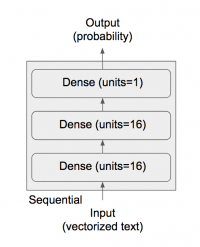

Implementation of the following architecture:

- Two intermediate layers with 16 hidden units each, and a third layer which will output the scalar prediction regarding the sentiment of the current review.
- The intermediate layers will use relu as their “activation function”, and the final layer will use a <ins>`sigmoid`</ins> activation so as to output a probability (a score between 0 and 1, indicating how likely the sample is to have the target “1”, i.e. how likely the review is to be positive).
- A relu (rectified linear unit) is a function meant to zero-out negative values, while a sigmoid “squashes” arbitrary values into the [0, 1] interval, thus outputting something that can be interpreted as a probability.

In [ ]:
model = models.Sequential()

model.add(layers.Dense(units=16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 5. Network training

Since we are facing a binary classification problem and the output of our network is a probability (we end our network with a single-unit layer with a sigmoid activation), is it best to use the `binary_crossentropy` loss. It isn't the only viable choice: you could use, for instance, mean_squared_error. But `crossentropy` is usually the best choice when you are dealing with models that output probabilities. Crossentropy is a quantity from the field of Information Theory, that measures the “distance” between probability distributions, or in our case, between the ground-truth distribution and our predictions.

To configure the model please use the following parameters:
- `rmsprop` optimizer
- `binary_crossentropy` loss function
- `accuracy` metric

In [ ]:
model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │         160,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,305 (626.19 KB)

 Trainable params: 160,305 (626.19 KB)

 Non-trainable params: 0 (0.00 B)

### 6. Validation

In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a “validation set” by setting apart 10,000 samples from the original data (suggested split: 25000 train, 10000 validation, 15000 test). You can do it manually or use `train_test_split` from `sklearn` library:

In [ ]:
# we'll split the x_train and y_train to create the validation set.
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=10000, random_state=42)


### 7. Train the model

Train the model with following parameters:
- x_train, y_train -remained
- epochs - 20
- batch_size - 512
- validation_data=(x_val, y_val)

In [ ]:
history = model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.6790 - loss: 0.6126 - val_accuracy: 0.8502 - val_loss: 0.4209
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.8898 - loss: 0.3584 - val_accuracy: 0.8704 - val_loss: 0.3353
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.9243 - loss: 0.2498 - val_accuracy: 0.8855 - val_loss: 0.2926
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.9370 - loss: 0.2007 - val_accuracy: 0.8853 - val_loss: 0.2861
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9476 - loss: 0.1679 - val_accuracy: 0.8846 - val_loss: 0.2897
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9572 - loss: 0.1416 - val_accuracy: 0.8813 - val_loss: 0.2928
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9642 - loss: 0.1202 - val_accuracy: 0.8792 - val_loss: 0.3121
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9709 - loss: 0.1027 - val_accuracy: 0.8768 - 

The history = model.fit() returns a History object. This object has a member history, which is a dictionary containing data about everything that happened during training. Let's take a look at it:

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

It contains 4 entries: one per metric that was being monitored, during training and during validation. Please use Matplotlib to plot the training and validation loss side by side, as well as the training and validation accuracy.

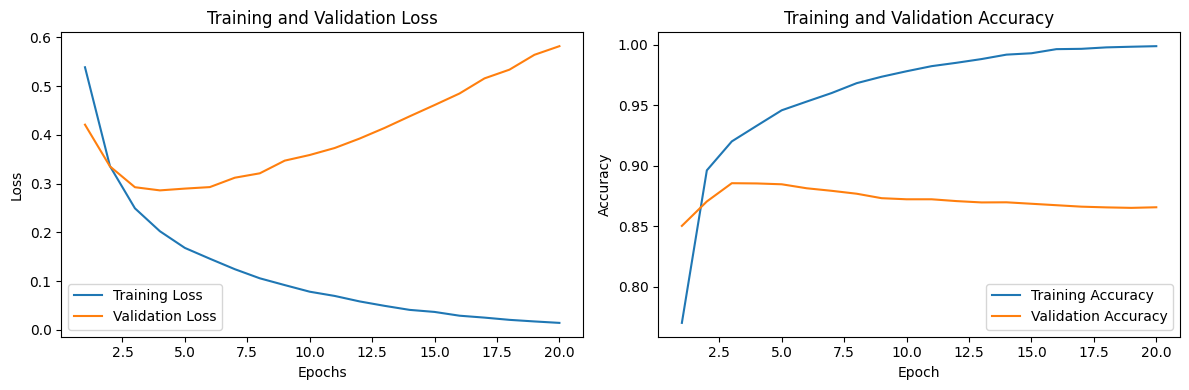

In [ ]:
history = model.history.history

# Extract training and validation loss and accuracy
training_loss = history['loss']
validation_loss = history['val_loss']
training_accuracy = history['accuracy']
validation_accuracy = history['val_accuracy']

plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(training_loss) + 1), training_loss, label='Training Loss')
plt.plot(range(1, len(validation_loss) + 1), validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, label='Training Accuracy')
plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

As you can see, the training loss decreases with every epoch, and the training accuracy increases with every epoch. In precise terms, what you are seeing is “overfitting”: after the second epoch, we are over-optimizing on the training data, and we ended up learning representations that are specific to the training data and do not generalize to data outside of the training set.

Please check how that model performs on the test set too!!

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8560 - loss: 0.5863
Test Loss: 0.5817
Test Accuracy: 0.8588


## **Part 2 Hyperparameters**

As we stated before, there is no ideal solution to each deep learning task. To decide how many layers to add or which activation functions use you need practice and usually a lot of trials and errors. Some people even say that implementing a neural network from scratch is more art than science.

#### **Parameter optimisation**

Even then, after you decide what your model will look like, there is a matter of training, which also requires additional parameters. These numbers, that you already encountered, like a number of epochs, learning rate or optimizer are called hyperparameters. Training a neural network is basically an optimization problem, so you can think of setting those parameters as optimizing an optimization. It's not an easy task. There are, however, some tools that can help with that.


#### **Callbacks**

One of the simplest methods helpful in parameter selection is using Callbacks. These are basic functions that let you act on the model during training. They allow you to interrupt training to save a model, load a different weight set, or otherwise alter the state of the model. Here are some examples of ways you can use callbacks:

- Model checkpointing - saving the current weights of the model at different points during training.
- Early stopping - interrupting training when the validation loss is no longer improving (and of course, saving the best model obtained during training).
- Dynamically adjusting the value of certain parameters during training - such as the learning rate of the optimizer.
- Logging training and validation metrics during training, or visualizing the representations learned by the model as they’re updated.

There are many default methods that you can explore in `keras.callbacks` such as `ModelCheckpoint`, `EarlyStopping` or `LearningRateScheduler`. However, one of the most useful things is that you can define your own callback and pass it to the model. So first, check if the desired functionality is available in Keras and if it isn't write it yourself.

To do so, you can use functions that trigger when certain action occurs:

- `on_epoch_begin`
- `on_epoch_end`
- `on_batch_begin`
- `on_batch_end`
- `on_train_begin`
- `on_train_end`

You can define function behavior after the trigger. In an example below, we check after each epoch if the training accuracy reaches a certain threshold (in this case 90%). If it does, we stop training. This is a useful method to decide on a number of epochs and avoid overfitting. You can read more about callbacks in [Keras Callbacks Documentation](https://keras.io/api/callbacks).


First, you need to define a callback class:

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

Then create a callback instance and pass it as an argument when using `.fit()` or `.fit_generator()`:

In [ ]:
callbacks = myCallback()

model.fit(x_train, y_train, epochs=10, callbacks=[callbacks])

Epoch 1/10
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9975 - loss: 0.0150
Reached 90% accuracy so cancelling training!
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9975 - loss: 0.0150


#### **Optimisation algorithms from sklearn**



There are various algorithms that automatically set different parameters, run training, and repeat the process. For example, the Scikit-Learn library provides [Grid Search Method](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or [Random Search Method](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). You can read more about them in the documentation. More sophisticated methods, like genetic algorithms or particle swarm optimization, are sometimes used too.

Current task is to use Grid Search Optimisation algorithm to optimise one of the networks from previous weeks. Choose two parameters (for example number of epochs and batch size) and try two different values for each parameter. Grid Search method will therefore create a mesh of these parameters, with four elements (2×2). This process will take more time and computation power, as it will basically train the model four times and compare results. If you don't have a good computer it is best to try it on simple mnist or imdb classification.

In [ ]:
def create_model():
    network = models.Sequential()

    network.add(layers.Dense(units=16, activation='relu', input_shape=(10000,)))
    network.add(layers.Dense(units=16, activation='relu'))
    network.add(layers.Dense(units=1, activation='sigmoid'))

    network.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
    return network

model = KerasClassifier(build_fn=create_model)

# Define grid search parameters
par1_batch = [32, 64]
par2_epoch = [3, 5]

param_grid = dict(batch_size=par1_batch,
                  epochs=par2_epoch
                  )

grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv = 3
                    )

# grid_results = grid.fit(X,Y)
grid_results = grid.fit(x_train,y_train)

# Print best results
print("Best: %f using %s" % (grid_results.best_score_, grid_results.best_params_))


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7663 - loss: 0.5023
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9441 - loss: 0.1601
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9773 - loss: 0.0813
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7725 - loss: 0.4920
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9514 - loss: 0.1529
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9773 - loss: 0.0755
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7682 - loss: 0.5032
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9502 - loss: 0.1548
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9789 - loss: 0.0759
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6760 - loss: 0.5788
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9373 - loss: 0.1823
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9739 - loss: 0.0914
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9921 - loss: 0.0368
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9973 - loss: 0.0156
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6928 - loss: 0.5267
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9487 - loss: 0.1560
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9768 - loss: 0.0827
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9931 - loss: 0.0341
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9987 - loss: 0.0130
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7906 - loss: 0.4894
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9483 - loss: 0.1553
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9812 - loss: 0.0720
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9934 - loss: 0.0343
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9984 - loss: 0.0165
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7770 - loss: 0.5271
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9448 - loss: 0.1704
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9769 - loss: 0.0865
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7502 - loss: 0.5118
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9414 - loss: 0.1706
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9785 - loss: 0.0855
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7505 - loss: 0.5349
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9463 - loss: 0.1685
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9804 - loss: 0.0800
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7588 - loss: 0.5255
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9427 - loss: 0.1719
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9782 - loss: 0.0892
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9906 - loss: 0.0484
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9963 - loss: 0.0245
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7557 - loss: 0.5263
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9461 - loss: 0.1698
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9762 - loss: 0.0869
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9918 - loss: 0.0432
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9980 - loss: 0.0167
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7451 - loss: 0.5222
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9482 - loss: 0.1593
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9803 - loss: 0.0770
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9910 - loss: 0.0403
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9979 - loss: 0.0171
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7584 - loss: 0.5012
Epoch 2/3
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9412 - loss: 0.1790
Epoch 3/3
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9676 - loss: 0.1078
Best: 0.875200 using {'batch_size': 64, 'epochs': 3}


#### **Optimisation algorithms from Keras**

One of the latest trends in Deep Learning (first introduced in 2019) is Keras Autotuner. Basically, it follows the same idea as the Scikit-Learn approach described above (Grid Search, Random Search or other) but is provided by Keras. If you want, you can try it instead of the above. However, you need to have `keras-tuner` installed, which requires `Python 3.6+` and `TensorFlow 2.0+`.

- [Keras Tuner - Documentation](https://keras.io/keras_tuner/)
- [Keras Tuner - Tutorial](https://keras.io/guides/keras_tuner/getting_started/)
- [Keras Tuner - training parameters](https://github.com/keras-team/keras-tuner/issues/122)

Wrap a model inside a function, with optimised parameters as arguments. In the example below we optimise the number of neurons in a Dense layer.

In [ ]:
# Define the parameterized model
def build_model(hp):
    network = models.Sequential()

    # Use hp.Int to specify the number of units in the Dense layer, range from 16 to 64 with a step size of 16
    network.add(layers.Dense(units=hp.Int('units', min_value=16, max_value=64, step=16), activation='relu', input_shape=(10000,)))
    network.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    network.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

    return network

Set up a Random Search tuner (there are many different tuners available) with a model, objective function and max number of iterations. Then run search with all the parameters that you would normally pass to a `fit` funtion.

In [ ]:
# Set up Keras Tuner's RandomSearch
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)

# Run the hyperparameter search
tuner.search(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_val, y_val))

# Get the model with the best hyperparameters
best_model = tuner.get_best_models()[0]

Trial 4 Complete [00h 00m 18s]
val_loss: 0.28599411249160767

Best val_loss So Far: 0.28583475947380066
Total elapsed time: 00h 01m 31s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
